# Solving the Titanic Challenge

<img src="../images/titanic.png" width="300" align="center" />

<br>

## 🚢 Introduction

The Titanic problem centers on predicting the survival of passengers from the infamous 1912 disaster, where the RMS Titanic sank after colliding with an iceberg. This challenge not only tests our ability to analyze historical data but also our skills in data science to make informed predictions.

We will tackle this problem through several key steps:

1. **Exploratory Data Analysis (EDA):** We'll begin by exploring the dataset to understand the underlying patterns and distributions. This involves visualizing and summarizing the data to identify significant features that might impact survival, such as age, gender, class, and more.

2. **Feature Engineering:** This step involves creating new features or modifying existing ones to better capture the relationships within the data. For example, we might create a new feature that combines age and class, or we might handle missing values in a way that preserves the integrity of the dataset.

3. **Machine Learning:** Using the cleaned and engineered dataset, we'll apply various machine learning algorithms to build predictive models. These models will help us identify the factors most strongly associated with survival and allow us to predict the survival probability of passengers based on their attributes.

By the end of this analysis, we aim to have a robust model that can accurately predict the likelihood of survival for individuals on the Titanic, providing insights into how different characteristics influenced the chances of surviving one of history's most infamous maritime disasters.


> 🔑 **Note**: To learn more about this challenge, we invite you to use the following resources:
> 
>  * [📖 Docs](https://fralfaro.github.io/Titanic-Challenge/): Official documentation of the Titanic Challenge (using MkDocs together with GitHub Actions and GitHub Pages).
>  * [👑 Streamlit](https://titanic-challenge-fralfaro.streamlit.app/): An interactive way to learn about the Titanic Challenge (featuring amazing libraries like `great_tables`, `itables`, `plotly` and more!).

##  📊 EDA

Exploratory Data Analysis (EDA) is a crucial step in any data analysis project. It involves examining the dataset to uncover underlying patterns, spot anomalies, test hypotheses, and check assumptions through summary statistics and graphical representations. For the Titanic dataset, EDA helps us understand the factors that influenced survival rates, such as passenger demographics, socio-economic status, and travel details.

The dataset comprises variables such as passenger age, gender, ticket class, fare paid, and whether or not the passenger survived. By analyzing these variables, we can gain insights into which groups of passengers were more likely to survive and the reasons behind these trends. For instance, we might explore questions like:

- Did gender play a significant role in survival rates?
- Were first-class passengers more likely to survive than those in lower classes?
- How did the age of passengers affect their chances of survival?

Through various visualizations and statistical analyses, EDA provides a foundation for more complex modeling and predictive analysis. It allows us to clean and preprocess the data, handle missing values, and create new features that might improve the performance of machine learning models.

### About Data


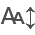

In [1]:
# librerias
from loguru import logger
import pandas as pd
from itables import init_notebook_mode, show
from great_tables import GT, html
from utils import * 

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
init_notebook_mode(all_interactive=True)

In [2]:
def gt_tables(table,col,vo):
    # Flattening the MultiIndex columns
    table.columns = [f'{i}_{j}' for i, j in table.columns]

    # Resetting the index to make 'FareRange' a column again
    table.reset_index(inplace=True)

    # Displaying the DataFrame
    gt_table = ((
        GT(table)
        .tab_header(
            title="Count and Percentage Table",
            subtitle=f"{col} vs {vo}"
        )

        .tab_spanner(
            label="0",
            columns=["Count_0", "Percentage_0"]
        )
        .tab_spanner(
            label="1",
            columns=["Count_1", "Percentage_1"]
        )
        .tab_spanner(
            label=vo,
            columns=["Count_0", "Percentage_0", "Count_1", "Percentage_1"]
        )

        .cols_label(
            Count_0=html("Count"),
            Count_1=html("Count"),
            Percentage_0=html("Percentage"),
            Percentage_1=html("Percentage")

        )
    )
    )
    gt_table = gt_table.fmt_number(columns=["Percentage_0", "Percentage_1"],
                                   decimals=2)  # .opt_stylize(style = 1, color = "blue")

    gt_table = gt_table.tab_options(
        table_background_color="white",
        # table_font_color="darkblue",
        table_font_style="italic",
        table_font_names="Times New Roman",
        heading_background_color="skyblue"
    )
    
    return gt_table

In [3]:
logger.info("Read Data")

# path
path_raw = "data/raw/"

# read data
train = pd.read_csv(path_raw + "train.csv")
test = pd.read_csv(path_raw + "test.csv")

# display data
show(train, classes="display nowrap compact",maxBytes = 0)

2024-06-10 08:35:04.542 | INFO     | __main__:<module>:1 - Read Data


In [4]:
# information about the data types and non-null values in each column
print("TRAIN:")
train.info()

TRAIN:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


>  🔑**Note**: For now, we will focus on the train dataset, but the same should be done for the test dataset.

In [5]:
# check for duplicates in the dataset
duplicates = train.duplicated()

# count the number of duplicate rows
num_duplicates = duplicates.sum()
print("duplicate rows:", num_duplicates)

duplicate rows: 0


To perform an Exploratory Data Analysis (EDA) with visualizations, whether univariate, bivariate or not, it is essential to consider the type of data we are working with. Additionally, we can perform a deep scan of all columns or an in-depth scan of individual columns, depending on the desired speed and detail of our EDA. The goal is to present all findings in a detailed and clear manner to ensure maximum understanding.

In [6]:
# get column names by data types
target = 'Survived'

float_columns = [x for x in list(train.select_dtypes(include=['float64']).columns) if x != target]
integer_columns = [x for x in list(train.select_dtypes(include=['int32', 'int64']).columns) if x != target]
object_columns = [x for x in list(train.select_dtypes(include=['object']).columns) if x != target]

# display column names by data type
print(f"Target: {target}")
print()
print("Total float columns:", len(float_columns))
print("Float columns:", float_columns)
print()
print("Total integer columns:", len(integer_columns))
print("Integer columns:", integer_columns)
print()
print("Total object columns:", len(object_columns))
print("Object columns:", object_columns)

Target: Survived

Total float columns: 2
Float columns: ['Age', 'Fare']

Total integer columns: 4
Integer columns: ['PassengerId', 'Pclass', 'SibSp', 'Parch']

Total object columns: 5
Object columns: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In this case, the 'Age' column should be an integer, but it contains null values (or NaN), which automatically converts it to a float type column. For now, let's treat it as a float type column.

### About EDA

There are columns used to identify each individual, typically indicated by the term 'ID' in their name. It is essential that these identifiers do not have a value of zero.

It is important to note that these identifiers should not be duplicated unless there is more than one record due to analysis in relation to other columns (e.g., the **period**). In these specific cases, duplication may be relevant and is associated with certain analytical contexts involving other variables or time periods.

In [7]:
logger.info("EDA")
logger.info('PassengerId')
total_nulls = train['PassengerId'].isnull().sum()
print(f"Total null values: {total_nulls} ")

2024-06-10 08:35:04.628 | INFO     | __main__:<module>:1 - EDA
2024-06-10 08:35:04.629 | INFO     | __main__:<module>:2 - PassengerId


Total null values: 0 


In [8]:
# Set as index
train = train.set_index('PassengerId')
show(train, classes="display nowrap compact",maxBytes = 0)

Now, we will proceed to work on the remaining columns.

To analyze variables with float values, the approach depends on the distribution of the data. For univariate analysis, a Histogram is usually used as a starting point (First Case). However, if the dataset is extensive or there is a noticeable concentration of values around zero (a common scenario), it is more effective to transform the data into discrete intervals (Second Case).

The definition of these intervals can be done automatically using a function that generates equidistant ranges. However, sometimes it is preferable to define these intervals manually, as automation could create numerous bins, making data interpretation and analysis more difficult. In such cases, a manual approach allows for adjusting the intervals more appropriately according to the specific nature of the data, facilitating better understanding and analysis.

2024-06-10 08:35:04.672 | INFO     | __main__:<module>:1 - floats: ['Age', 'Fare']


Column: Age

Univariate Analysis


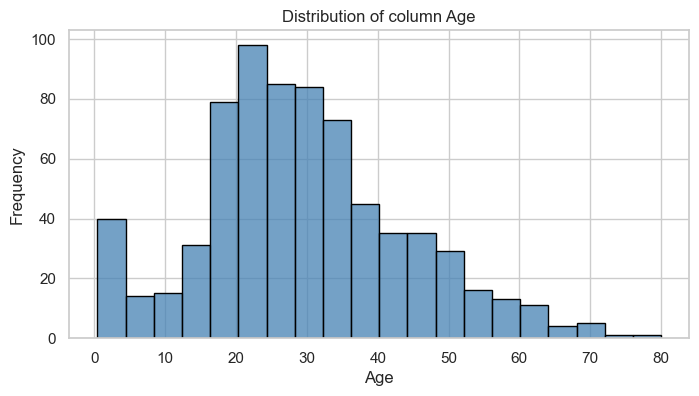

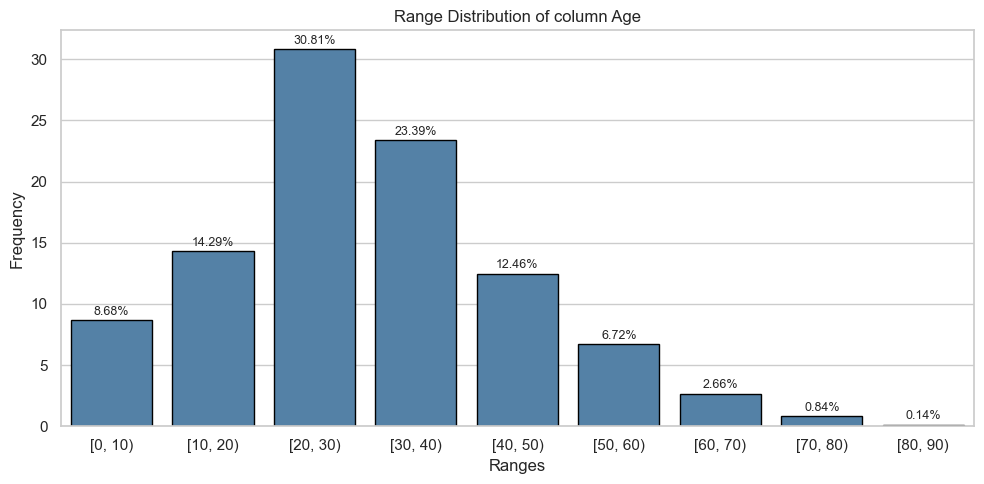

Bivariate Analysis


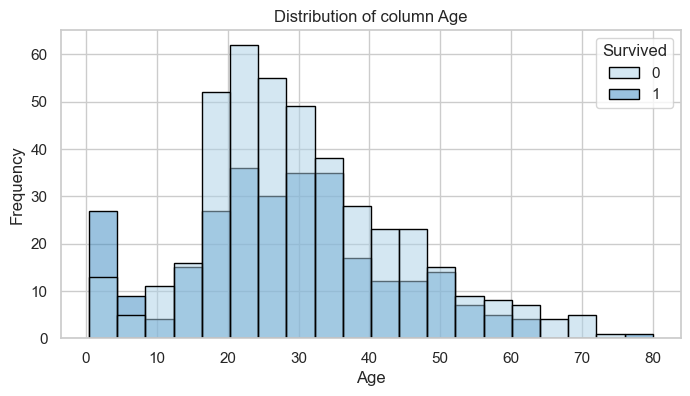

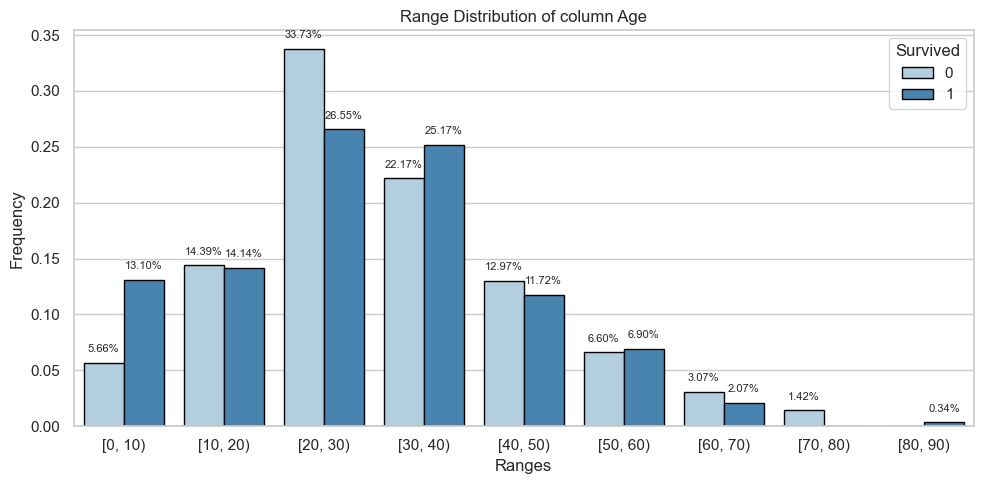

Tables


GT(_tbl_data=   AgeRange  Count_0  Count_1  Percentage_0  Percentage_1
0   [0, 10)   24.000   38.000         0.057         0.131
1  [10, 20)   61.000   41.000         0.144         0.141
2  [20, 30)  143.000   77.000         0.337         0.266
3  [30, 40)   94.000   73.000         0.222         0.252
4  [40, 50)   55.000   34.000         0.130         0.117
5  [50, 60)   28.000   20.000         0.066         0.069
6  [60, 70)   13.000    6.000         0.031         0.021
7  [70, 80)    6.000    0.000         0.014         0.000
8  [80, 90)    0.000    1.000         0.000         0.003, _body=<great_tables._gt_data.Body object at 0x00000225114E83A0>, _boxhead=Boxhead([ColInfo(var='AgeRange', type=<ColInfoTypeEnum.default: 1>, column_label='AgeRange', column_align='center', column_width=None), ColInfo(var='Count_0', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Count', type='html'), column_align='right', column_width=None), ColInfo(var='Percentage_0', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Percentage', type='html'), column_align='right', column_width=None), ColInfo(var='Count_1', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Count', type='html'), column_align='right', column_width=None), ColInfo(var='Percentage_1', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Percentage', type='html'), column_align='right', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=2, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=3, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=4, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=5, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=6, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=7, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=8, group_id=None, rowname=None, group_label=None, built=False)]), _row_groups=[], _group_rows=GroupRows([]), _spanners=Spanners([SpannerInfo(spanner_id='0', spanner_level=0, spanner_label='0', spanner_units=None, spanner_pattern=None, vars=['Count_0', 'Percentage_0'], built=None), SpannerInfo(spanner_id='1', spanner_level=0, spanner_label='1', spanner_units=None, spanner_pattern=None, vars=['Count_1', 'Percentage_1'], built=None), SpannerInfo(spanner_id='Survived', spanner_level=1, spanner_label='Survived', spanner_units=None, spanner_pattern=None, vars=['Count_0', 'Percentage_0', 'Count_1', 'Percentage_1'], built=None)]), _heading=Heading(title='Count and Percentage Table', subtitle='Age vs Survived', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x00000225118C9E10>, _formats=[<great_tables._gt_data.FormatInfo object at 0x00000225118AE7D0>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='white'), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['Times New Roman']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value=

Column: Fare

Univariate Analysis


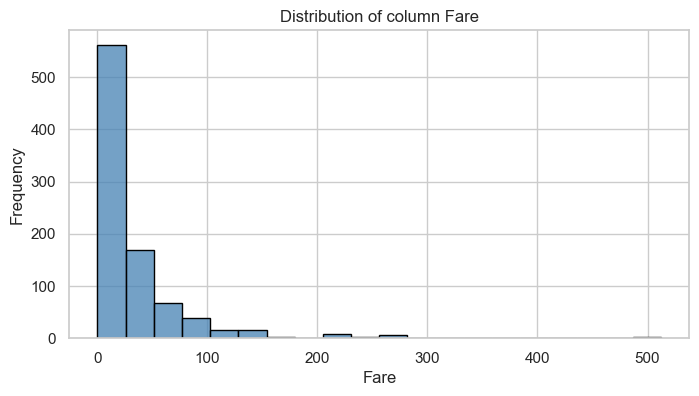

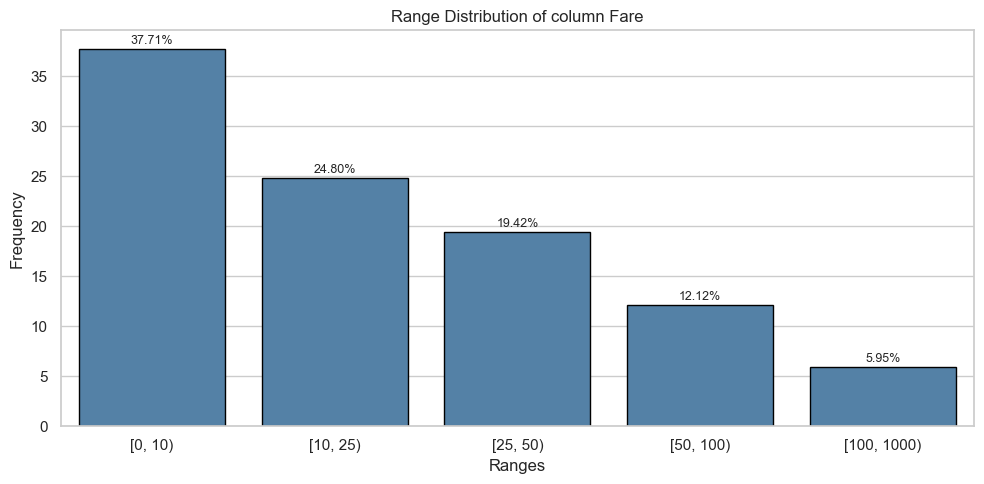

Bivariate Analysis


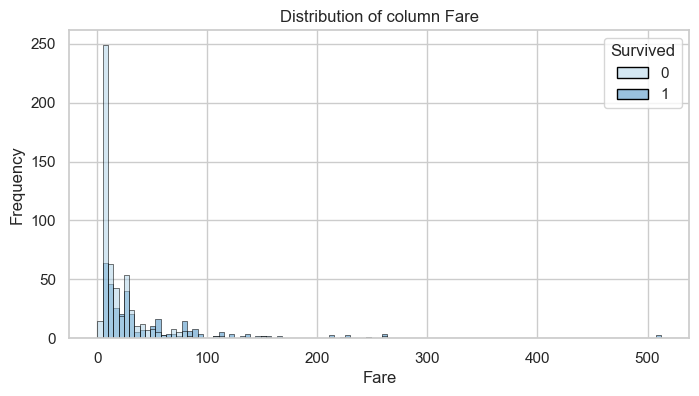

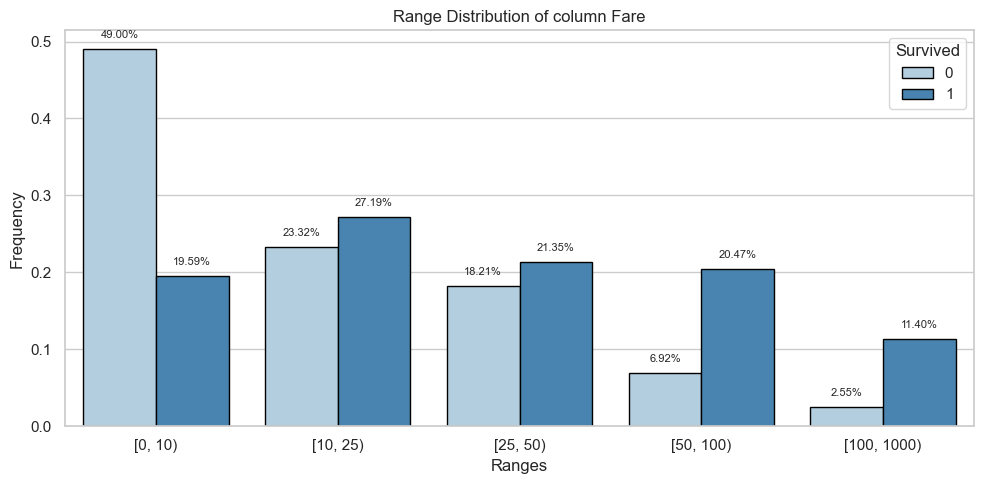

Tables


GT(_tbl_data=     FareRange  Count_0  Count_1  Percentage_0  Percentage_1
0      [0, 10)  269.000   67.000         0.490         0.196
1     [10, 25)  128.000   93.000         0.233         0.272
2     [25, 50)  100.000   73.000         0.182         0.213
3    [50, 100)   38.000   70.000         0.069         0.205
4  [100, 1000)   14.000   39.000         0.026         0.114, _body=<great_tables._gt_data.Body object at 0x00000225115A3130>, _boxhead=Boxhead([ColInfo(var='FareRange', type=<ColInfoTypeEnum.default: 1>, column_label='FareRange', column_align='center', column_width=None), ColInfo(var='Count_0', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Count', type='html'), column_align='right', column_width=None), ColInfo(var='Percentage_0', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Percentage', type='html'), column_align='right', column_width=None), ColInfo(var='Count_1', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Count', type='html'), column_align='right', column_width=None), ColInfo(var='Percentage_1', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Percentage', type='html'), column_align='right', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=2, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=3, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=4, group_id=None, rowname=None, group_label=None, built=False)]), _row_groups=[], _group_rows=GroupRows([]), _spanners=Spanners([SpannerInfo(spanner_id='0', spanner_level=0, spanner_label='0', spanner_units=None, spanner_pattern=None, vars=['Count_0', 'Percentage_0'], built=None), SpannerInfo(spanner_id='1', spanner_level=0, spanner_label='1', spanner_units=None, spanner_pattern=None, vars=['Count_1', 'Percentage_1'], built=None), SpannerInfo(spanner_id='Survived', spanner_level=1, spanner_label='Survived', spanner_units=None, spanner_pattern=None, vars=['Count_0', 'Percentage_0', 'Count_1', 'Percentage_1'], built=None)]), _heading=Heading(title='Count and Percentage Table', subtitle='Fare vs Survived', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x00000225117CDAE0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x00000225115764D0>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='white'), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['Times New Roman']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='italic'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='tab

In [9]:
logger.info(f"floats: {float_columns}")

bins = {
    'Age': [0, 10, 20, 30, 40, 50, 60, 70, 80, 90],
    'Fare':  [0, 10, 25, 50, 100, 1000]
}

target = 'Survived'

for col in float_columns: 
    print(f"Column: {col}\n")
    print("Univariate Analysis")
    plot_histogram(train, col)
    plot_range_distribution(train, col, bins[col], figsize=(10, 5))
    print("Bivariate Analysis")
    plot_histogram_vo(train, col, target)
    plot_range_distribution_vo(train, col, bins[col], target, figsize=(10, 5))
    print("Tables")
    table = calculate_percentage_vo(train, col, bins[col], target)
    table = gt_tables(table,col,target)
    display(table)

To visually represent variables of type `int` or `object`, it is initially recommended to use the `value_counts` method from Pandas to count the unique values in that column. However, different considerations should be taken into account:

- When the number of unique values is small, it is appropriate to use `value_counts` directly for both `int` and `object` type variables.
- For `int` type variables with a large number of categories, it is useful to work with **value intervals** before creating graphical visualizations.
- For `object` type variables with multiple categories, it may be helpful to prioritize the most frequent ones and group the rest under a general label such as "others". However, if most values are unique, that variable may not provide relevant information for graphical representation (e.g., information such as addresses, phone numbers, emails, etc.).

2024-06-10 08:35:05.921 | INFO     | __main__:<module>:1 - Integers: ['PassengerId', 'Pclass', 'SibSp', 'Parch']
2024-06-10 08:35:05.922 | INFO     | __main__:<module>:2 - Objects: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


Pclass
Univariate Analysis


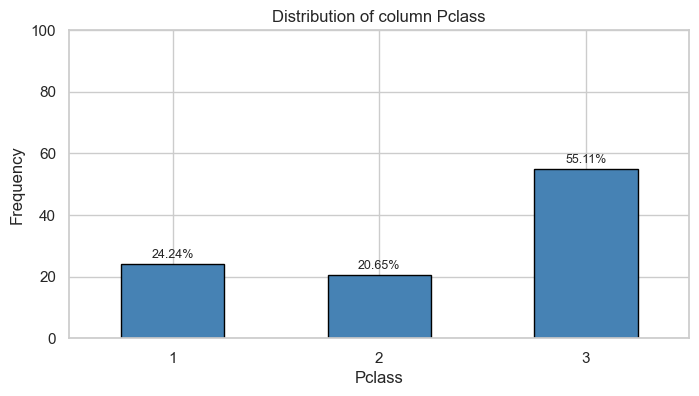

Bivariate Analysis


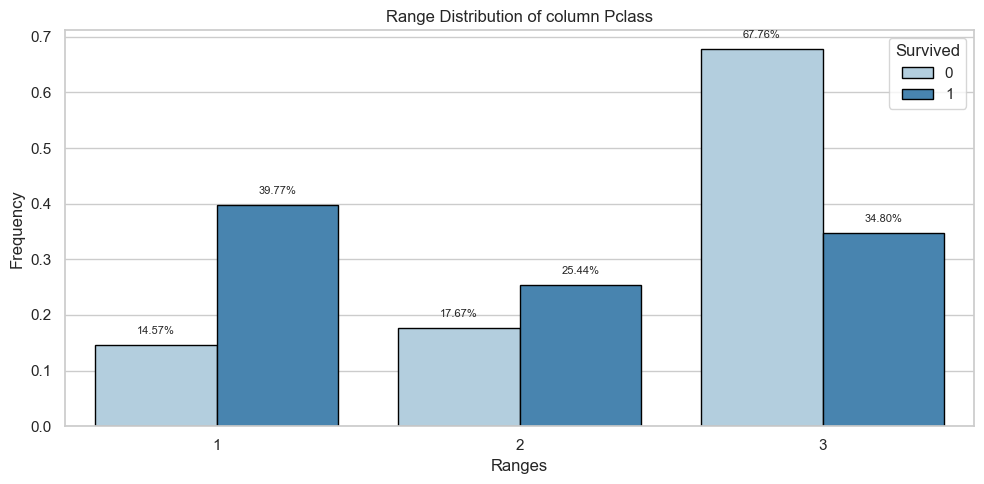

Tables


GT(_tbl_data=   Pclass  Count_0  Count_1  Percentage_0  Percentage_1
0       1   80.000  136.000         0.146         0.398
1       2   97.000   87.000         0.177         0.254
2       3  372.000  119.000         0.678         0.348, _body=<great_tables._gt_data.Body object at 0x00000225115A30A0>, _boxhead=Boxhead([ColInfo(var='Pclass', type=<ColInfoTypeEnum.default: 1>, column_label='Pclass', column_align='right', column_width=None), ColInfo(var='Count_0', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Count', type='html'), column_align='right', column_width=None), ColInfo(var='Percentage_0', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Percentage', type='html'), column_align='right', column_width=None), ColInfo(var='Count_1', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Count', type='html'), column_align='right', column_width=None), ColInfo(var='Percentage_1', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Percentage', type='html'), column_align='right', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=2, group_id=None, rowname=None, group_label=None, built=False)]), _row_groups=[], _group_rows=GroupRows([]), _spanners=Spanners([SpannerInfo(spanner_id='0', spanner_level=0, spanner_label='0', spanner_units=None, spanner_pattern=None, vars=['Count_0', 'Percentage_0'], built=None), SpannerInfo(spanner_id='1', spanner_level=0, spanner_label='1', spanner_units=None, spanner_pattern=None, vars=['Count_1', 'Percentage_1'], built=None), SpannerInfo(spanner_id='Survived', spanner_level=1, spanner_label='Survived', spanner_units=None, spanner_pattern=None, vars=['Count_0', 'Percentage_0', 'Count_1', 'Percentage_1'], built=None)]), _heading=Heading(title='Count and Percentage Table', subtitle='Pclass vs Survived', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000022511EF69E0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x0000022511575FC0>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='white'), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['Times New Roman']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='italic'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value=

SibSp
Univariate Analysis


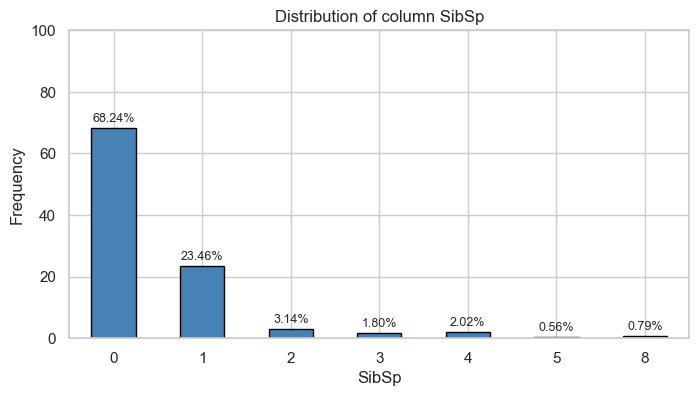

Bivariate Analysis


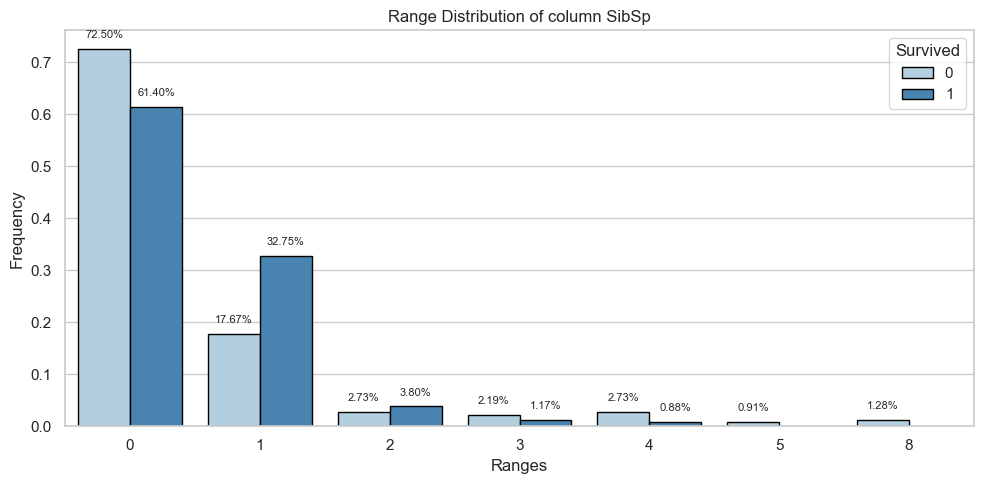

Tables


GT(_tbl_data=   SibSp  Count_0  Count_1  Percentage_0  Percentage_1
0      0  398.000  210.000         0.725         0.614
1      1   97.000  112.000         0.177         0.327
2      2   15.000   13.000         0.027         0.038
3      3   12.000    4.000         0.022         0.012
4      4   15.000    3.000         0.027         0.009
5      5    5.000    0.000         0.009         0.000
6      8    7.000    0.000         0.013         0.000, _body=<great_tables._gt_data.Body object at 0x00000225122E4190>, _boxhead=Boxhead([ColInfo(var='SibSp', type=<ColInfoTypeEnum.default: 1>, column_label='SibSp', column_align='right', column_width=None), ColInfo(var='Count_0', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Count', type='html'), column_align='right', column_width=None), ColInfo(var='Percentage_0', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Percentage', type='html'), column_align='right', column_width=None), ColInfo(var='Count_1', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Count', type='html'), column_align='right', column_width=None), ColInfo(var='Percentage_1', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Percentage', type='html'), column_align='right', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=2, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=3, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=4, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=5, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=6, group_id=None, rowname=None, group_label=None, built=False)]), _row_groups=[], _group_rows=GroupRows([]), _spanners=Spanners([SpannerInfo(spanner_id='0', spanner_level=0, spanner_label='0', spanner_units=None, spanner_pattern=None, vars=['Count_0', 'Percentage_0'], built=None), SpannerInfo(spanner_id='1', spanner_level=0, spanner_label='1', spanner_units=None, spanner_pattern=None, vars=['Count_1', 'Percentage_1'], built=None), SpannerInfo(spanner_id='Survived', spanner_level=1, spanner_label='Survived', spanner_units=None, spanner_pattern=None, vars=['Count_0', 'Percentage_0', 'Count_1', 'Percentage_1'], built=None)]), _heading=Heading(title='Count and Percentage Table', subtitle='SibSp vs Survived', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000022511557460>, _formats=[<great_tables._gt_data.FormatInfo object at 0x00000225117CDA50>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='white'), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['Times New Roman']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='italic'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_t

Parch
Univariate Analysis


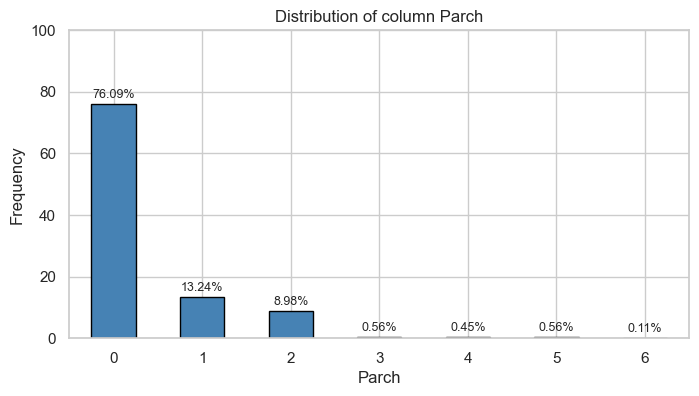

Bivariate Analysis


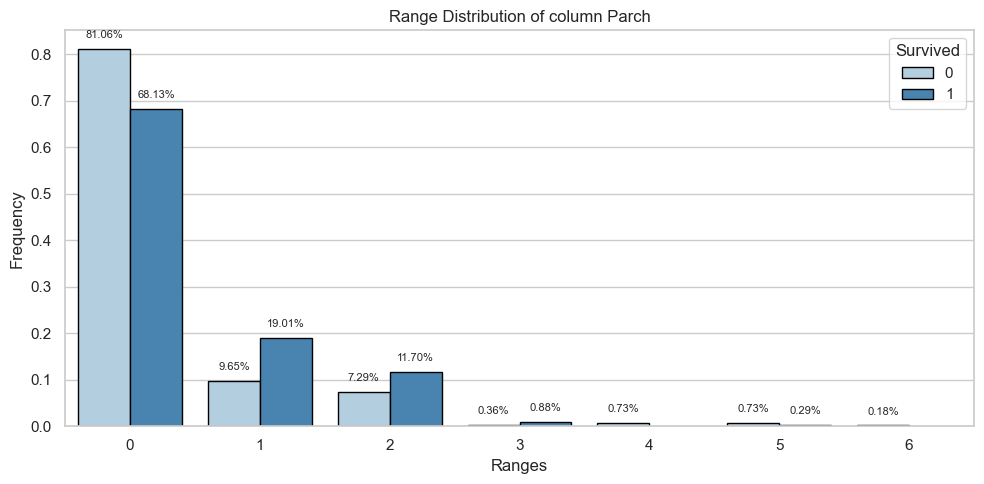

Tables


GT(_tbl_data=   Parch  Count_0  Count_1  Percentage_0  Percentage_1
0      0  445.000  233.000         0.811         0.681
1      1   53.000   65.000         0.097         0.190
2      2   40.000   40.000         0.073         0.117
3      3    2.000    3.000         0.004         0.009
4      4    4.000    0.000         0.007         0.000
5      5    4.000    1.000         0.007         0.003
6      6    1.000    0.000         0.002         0.000, _body=<great_tables._gt_data.Body object at 0x00000225114E83A0>, _boxhead=Boxhead([ColInfo(var='Parch', type=<ColInfoTypeEnum.default: 1>, column_label='Parch', column_align='right', column_width=None), ColInfo(var='Count_0', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Count', type='html'), column_align='right', column_width=None), ColInfo(var='Percentage_0', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Percentage', type='html'), column_align='right', column_width=None), ColInfo(var='Count_1', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Count', type='html'), column_align='right', column_width=None), ColInfo(var='Percentage_1', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Percentage', type='html'), column_align='right', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=2, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=3, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=4, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=5, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=6, group_id=None, rowname=None, group_label=None, built=False)]), _row_groups=[], _group_rows=GroupRows([]), _spanners=Spanners([SpannerInfo(spanner_id='0', spanner_level=0, spanner_label='0', spanner_units=None, spanner_pattern=None, vars=['Count_0', 'Percentage_0'], built=None), SpannerInfo(spanner_id='1', spanner_level=0, spanner_label='1', spanner_units=None, spanner_pattern=None, vars=['Count_1', 'Percentage_1'], built=None), SpannerInfo(spanner_id='Survived', spanner_level=1, spanner_label='Survived', spanner_units=None, spanner_pattern=None, vars=['Count_0', 'Percentage_0', 'Count_1', 'Percentage_1'], built=None)]), _heading=Heading(title='Count and Percentage Table', subtitle='Parch vs Survived', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x00000225115A30A0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x00000225117CD9F0>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='white'), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['Times New Roman']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='italic'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_t

Sex
Univariate Analysis


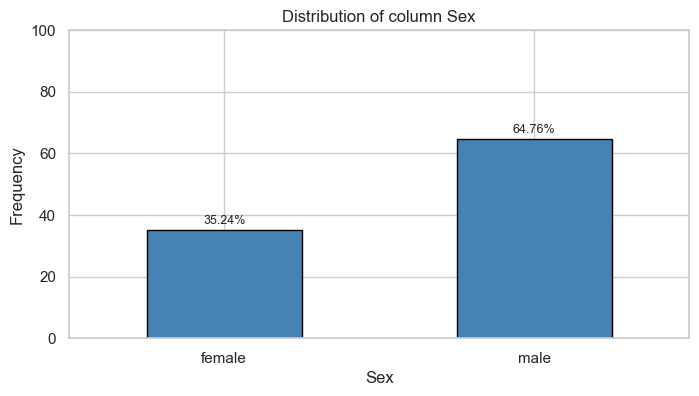

Bivariate Analysis


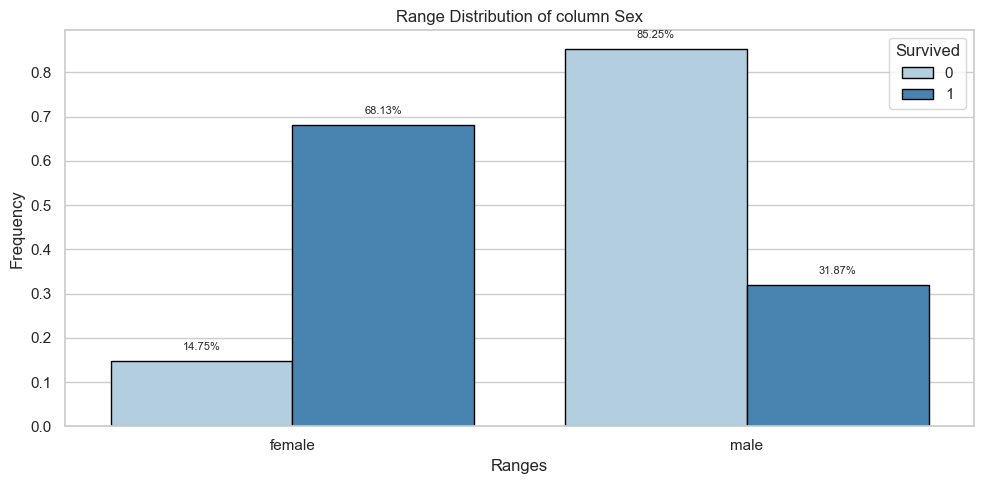

Tables


GT(_tbl_data=      Sex  Count_0  Count_1  Percentage_0  Percentage_1
0  female   81.000  233.000         0.148         0.681
1    male  468.000  109.000         0.852         0.319, _body=<great_tables._gt_data.Body object at 0x0000022511E47340>, _boxhead=Boxhead([ColInfo(var='Sex', type=<ColInfoTypeEnum.default: 1>, column_label='Sex', column_align='left', column_width=None), ColInfo(var='Count_0', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Count', type='html'), column_align='right', column_width=None), ColInfo(var='Percentage_0', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Percentage', type='html'), column_align='right', column_width=None), ColInfo(var='Count_1', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Count', type='html'), column_align='right', column_width=None), ColInfo(var='Percentage_1', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Percentage', type='html'), column_align='right', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=None, group_label=None, built=False)]), _row_groups=[], _group_rows=GroupRows([]), _spanners=Spanners([SpannerInfo(spanner_id='0', spanner_level=0, spanner_label='0', spanner_units=None, spanner_pattern=None, vars=['Count_0', 'Percentage_0'], built=None), SpannerInfo(spanner_id='1', spanner_level=0, spanner_label='1', spanner_units=None, spanner_pattern=None, vars=['Count_1', 'Percentage_1'], built=None), SpannerInfo(spanner_id='Survived', spanner_level=1, spanner_label='Survived', spanner_units=None, spanner_pattern=None, vars=['Count_0', 'Percentage_0', 'Count_1', 'Percentage_1'], built=None)]), _heading=Heading(title='Count and Percentage Table', subtitle='Sex vs Survived', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x00000225117CDAE0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x00000225115CA0E0>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='white'), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['Times New Roman']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='italic'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInf

Embarked
Univariate Analysis


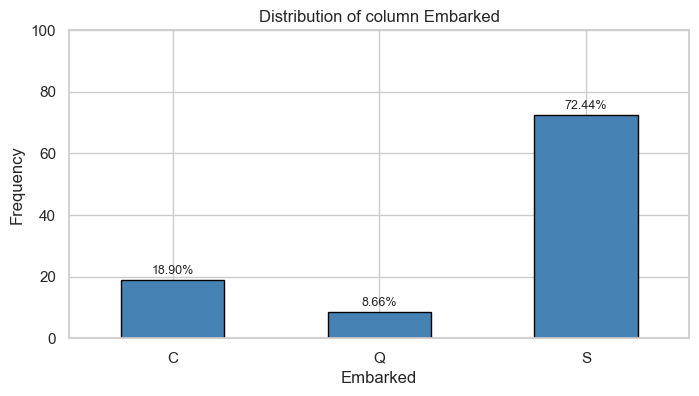

Bivariate Analysis


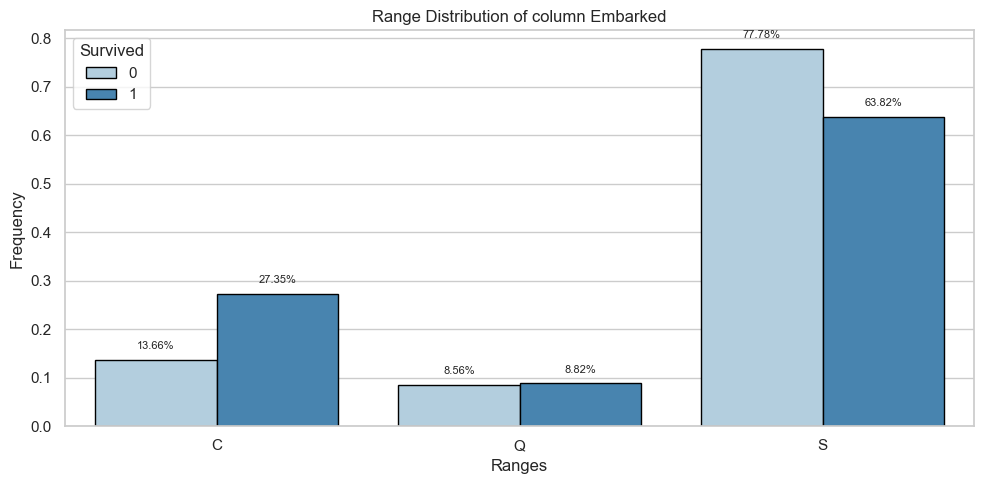

Tables


GT(_tbl_data=  Embarked  Count_0  Count_1  Percentage_0  Percentage_1
0        C   75.000   93.000         0.137         0.274
1        Q   47.000   30.000         0.086         0.088
2        S  427.000  217.000         0.778         0.638, _body=<great_tables._gt_data.Body object at 0x00000225128CFCD0>, _boxhead=Boxhead([ColInfo(var='Embarked', type=<ColInfoTypeEnum.default: 1>, column_label='Embarked', column_align='left', column_width=None), ColInfo(var='Count_0', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Count', type='html'), column_align='right', column_width=None), ColInfo(var='Percentage_0', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Percentage', type='html'), column_align='right', column_width=None), ColInfo(var='Count_1', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Count', type='html'), column_align='right', column_width=None), ColInfo(var='Percentage_1', type=<ColInfoTypeEnum.default: 1>, column_label=Text(text='Percentage', type='html'), column_align='right', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=2, group_id=None, rowname=None, group_label=None, built=False)]), _row_groups=[], _group_rows=GroupRows([]), _spanners=Spanners([SpannerInfo(spanner_id='0', spanner_level=0, spanner_label='0', spanner_units=None, spanner_pattern=None, vars=['Count_0', 'Percentage_0'], built=None), SpannerInfo(spanner_id='1', spanner_level=0, spanner_label='1', spanner_units=None, spanner_pattern=None, vars=['Count_1', 'Percentage_1'], built=None), SpannerInfo(spanner_id='Survived', spanner_level=1, spanner_label='Survived', spanner_units=None, spanner_pattern=None, vars=['Count_0', 'Percentage_0', 'Count_1', 'Percentage_1'], built=None)]), _heading=Heading(title='Count and Percentage Table', subtitle='Embarked vs Survived', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x00000225115C9DE0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x0000022511555570>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='white'), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['Times New Roman']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='italic'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value

In [10]:
logger.info(f"Integers: {integer_columns}")
logger.info(f"Objects: {object_columns}")

for col in ['Pclass', 'SibSp', 'Parch', 'Sex', 'Embarked']:
    print(col)
    print("Univariate Analysis")
    plot_barplot(train, col)
    print("Bivariate Analysis")
    plot_barplot_vo(train, col, target, figsize=(10, 5))
    print("Tables")
    table = calculate_percentage_vo_int(train, col, target).fillna(0)
    table = gt_tables(table,col,target)
    display(table)

To perform exploratory analysis on the 'Cabin', 'Name', and 'Ticket' columns in the Titanic dataset, you can follow various approaches depending on the information they contain and the specific objectives of your analysis.



### Conclusion

In conclusion, we conducted an Exploratory Data Analysis (EDA) on the Titanic dataset, focusing on understanding the characteristics and distribution of various columns. We identified the data types and non-null values, checked for duplicates, and performed univariate and bivariate analyses on numerical and categorical variables. Through graphical representations and interval-based transformations, we gained insights into the data's structure and key factors influencing survival rates. This comprehensive EDA serves as a foundation for further in-depth analysis and modeling.


## 📝 Feature Engineering

Feature engineering is a crucial step in the data preprocessing pipeline, aimed at enhancing the predictive power of machine learning models. For the Titanic dataset, this involves creating new features and modifying existing ones to better capture the underlying patterns that influence passenger survival.

The Titanic dataset includes various columns such as 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', and 'Embarked'. Each of these features holds potential insights into the survival outcomes, but they often require transformation and enrichment to become more effective for predictive modeling.

Feature engineering is an iterative process that involves experimenting with different transformations and evaluating their impact on model performance. By carefully crafting and selecting features, we can significantly improve the accuracy and robustness of predictive models for the Titanic dataset.

### Apply Feature Engineering


This stage offers numerous opportunities for a deeper analysis, especially when comparing with other columns. However, for our practical purposes, we will follow this approach:

* We will remove the 'Name' and 'Ticket' columns, as they do not initially contribute significantly to the model.
* For the 'Age' variable, we will fill the missing values with the mean age.
* We will address the 'Cabin' column by replacing the missing values with the most frequent value, thus optimizing data integrity.
* We will change the data type of the 'Pclass', 'SibSp', and 'Parch' variables.

In [11]:
logger.info("Remove variables: 'Name' and 'Ticket'")

cols_delete = ['Name', 'Ticket']

train = train.drop(cols_delete, axis=1)
test = test.drop(cols_delete, axis=1)

2024-06-10 08:35:07.054 | INFO     | __main__:<module>:1 - Remove variables: 'Name' and 'Ticket'


In [12]:
logger.info("Fill 'Age' with the mean")
age_mean = round(train['Age'].mean())

train['Age'] = train['Age'].fillna(age_mean)
test['Age'] = test['Age'].fillna(age_mean)

2024-06-10 08:35:07.070 | INFO     | __main__:<module>:1 - Fill 'Age' with the mean


In [13]:
logger.info("Modify and fill missing values in 'Cabin'")
train['Cabin'] = train['Cabin'].fillna('N').str[0]
test['Cabin'] = test['Cabin'].fillna('N').str[0]

2024-06-10 08:35:07.084 | INFO     | __main__:<module>:1 - Modify and fill missing values in 'Cabin'


In [14]:
logger.info("Change data type: 'Pclass', 'SibSp', and 'Parch'")

columns_to_convert = ['Pclass', 'SibSp', 'Parch']
train[columns_to_convert] = train[columns_to_convert].astype(str)
test[columns_to_convert] = test[columns_to_convert].astype(str)

2024-06-10 08:35:07.099 | INFO     | __main__:<module>:1 - Change data type: 'Pclass', 'SibSp', and 'Parch'


In [15]:
# Display train and test dataset
logger.info("New train data")
show(train, classes="display nowrap compact",maxBytes = 0)

2024-06-10 08:35:07.114 | INFO     | __main__:<module>:2 - New train data


In [16]:
logger.info("New test data")
show(test, classes="display nowrap compact",maxBytes = 0)

2024-06-10 08:35:07.145 | INFO     | __main__:<module>:1 - New test data


### Conclusion


In our feature engineering process for the Titanic dataset, we undertook several steps to prepare the data for effective modeling:

1. **Removal of Non-Contributory Columns:** We removed the 'Name' and 'Ticket' columns, as they did not provide significant predictive value for our model.
2. **Handling Missing Values:**
   - For the 'Age' column, missing values were filled with the mean age to maintain consistency and avoid data loss.
   - For the 'Cabin' column, missing values were replaced with the most frequent value ('N'), and only the first letter of the cabin was retained to simplify the data.
3. **Data Type Conversion:** The columns 'Pclass', 'SibSp', and 'Parch' were converted from numerical to string type to better capture categorical relationships.
4. **Data Saving:** The processed training and test datasets were saved for future modeling and analysis.

These feature engineering steps have improved the quality and usability of the dataset, ensuring that it is well-prepared for subsequent analysis and machine learning tasks. By addressing missing values, simplifying categorical data, and removing unnecessary columns, we have created a more robust and interpretable dataset for predicting passenger survival on the Titanic.

## 🤖 Machine Learning

The Titanic dataset is a popular and classic dataset used for introducing machine learning concepts and techniques. This dataset contains information about the passengers aboard the Titanic, including features such as age, gender, ticket class, and whether or not they survived the disaster. The primary objective is to build a predictive model that can accurately classify whether a passenger survived or not based on these features.

Machine learning offers a range of algorithms that can be applied to this classification problem. These algorithms can be broadly categorized into supervised learning techniques, where the model is trained on a labeled dataset. For the Titanic dataset, this means using the known outcomes (survived or not) to train the model.

Key steps in applying machine learning to the Titanic dataset include:

1. **Data Preprocessing:** This involves cleaning the data, handling missing values, and performing feature engineering to create relevant features that will improve the model's performance. The preprocessing steps ensure that the data is in a suitable format for training.

2. **Splitting the Data:** The dataset is typically split into a training set and a test set. The training set is used to train the model, while the test set is used to evaluate its performance.

3. **Selecting and Training Models:** Various machine learning algorithms can be applied to the Titanic dataset, including:
   - **Logistic Regression:** A simple and interpretable algorithm suitable for binary classification problems.
   - **Decision Trees:** A non-linear model that captures complex interactions between features.
   - **Random Forests:** An ensemble method that builds multiple decision trees and combines their predictions for improved accuracy.
   - **Support Vector Machines (SVM):** A powerful classifier that can find the optimal boundary between classes.
   - **Gradient Boosting:** An ensemble technique that builds models sequentially to correct errors made by previous models.

4. **Model Evaluation:** The performance of the models is evaluated using metrics such as accuracy, precision, recall, and the F1 score. Cross-validation techniques can also be employed to ensure the model's robustness and to prevent overfitting.

5. **Hyperparameter Tuning:** This involves optimizing the parameters of the chosen algorithms to improve their performance. Techniques like grid search or random search can be used for this purpose.

6. **Making Predictions:** Once the model is trained and evaluated, it can be used to make predictions on new, unseen data. In the case of the Titanic dataset, this would involve predicting the survival of passengers based on their features.

By applying machine learning techniques to the Titanic dataset, we can gain valuable insights into the factors that influenced survival and develop predictive models that can be used for similar classification tasks in other domains. The process also provides a practical introduction to key machine learning concepts and methods.

### Apply Machine Learning Models

In this section, we will apply various machine learning models to the Titanic dataset to predict passenger survival. By leveraging algorithms such as Logistic Regression, Decision Trees, Random Forests, Support Vector Machines (SVM), and Gradient Boosting, we aim to build and evaluate predictive models. These models will help us understand the key factors influencing survival and demonstrate the application of machine learning techniques to real-world data.

In [17]:
import joblib
import time

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
)

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [18]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    execution_time = time.time() - start_time

    y_pred = model.predict(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred), 3)

    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = round(roc_auc_score(y_test, y_prob), 3)

    evaluation_metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc,
        "Time": round(execution_time, 3),
    }

    return evaluation_metrics



def train_and_evaluate_all_models(models_dict, X_train, y_train, X_test, y_test):
    evaluation_results = {}
    for model_name, model in models_dict.items():
        evaluation_metrics = train_and_evaluate_model(
            model, X_train, y_train, X_test, y_test
        )
        evaluation_results[model_name] = evaluation_metrics

    results_df = pd.DataFrame.from_dict(evaluation_results, orient="index")
    return results_df

def preprocess_applier(preprocessor, X_data):
    # Apply preprocessing to the data
    X_data_processed = preprocessor.transform(X_data)

    # Get column names after preprocessing
    numeric_feature_names = preprocessor.transformers_[0][-1]
    categorical_feature_names = preprocessor.transformers_[1][-1]

    # Get the unique categories of the categorical variables
    unique_categories = preprocessor.named_transformers_["cat"]["onehot"].categories_

    # Create column names after OneHotEncoding
    encoded_categorical_feature_names = []
    for i, categories in enumerate(unique_categories):
        for category in categories:
            encoded_categorical_feature_names.append(
                f"{categorical_feature_names[i]}_{category}"
            )

    # Convert the sparse matrix to a Pandas DataFrame
    transformed_df = pd.DataFrame(
        X_data_processed.toarray(),
        columns=numeric_feature_names + encoded_categorical_feature_names,
    )

    return transformed_df

In [19]:
logger.info("Split the dataset into training and testing sets")

# Split the dataset into training and testing sets
target = 'Survived'
index_column = 'PassengerId'

features = [x for x in train.columns if x not in [target, index_column]]

X = train[features]
y = train[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Example of numeric and categorical variables
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Create transformers for numeric and categorical variables
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create the ColumnTransformer to apply transformations in a pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing to the training and testing data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get column names after preprocessing
numeric_feature_names = preprocessor.transformers_[0][-1]
categorical_feature_names = preprocessor.transformers_[1][-1]

# Get the unique categories of the categorical variables
unique_categories = preprocessor.named_transformers_['cat']['onehot'].categories_

# Create column names after OneHotEncoding
encoded_categorical_feature_names = []
for i, categories in enumerate(unique_categories):
    for category in categories:
        encoded_categorical_feature_names.append(f'{categorical_feature_names[i]}_{category}')

# Convert the sparse matrix to a Pandas DataFrame
transformed_train_df = pd.DataFrame(X_train_processed.toarray(), columns=numeric_feature_names + encoded_categorical_feature_names)
transformed_test_df = pd.DataFrame(X_test_processed.toarray(), columns=numeric_feature_names + encoded_categorical_feature_names)

2024-06-10 08:35:07.424 | INFO     | __main__:<module>:1 - Split the dataset into training and testing sets


In [20]:
# Models with optimized hyperparameters

# Initialize RandomForest classifier with optimized hyperparameters
random_forest = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='sqrt', 
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)

# Initialize LGBM classifier with optimized hyperparameters
lgbm = LGBMClassifier(random_state=42,
                      n_estimators=100,
                      learning_rate=0.1,
                      max_depth=-1)

# Initialize DecisionTree classifier with optimized hyperparameters
decision_tree = DecisionTreeClassifier(random_state=42,
                                       max_depth=None,
                                       min_samples_split=2,
                                       min_samples_leaf=1)

# Initialize KNeighbors classifier with optimized hyperparameters
knn = KNeighborsClassifier(n_neighbors=5,
                           weights='uniform',
                           p=2)

# Initialize LogisticRegression classifier with optimized hyperparameters
logistic_regression = LogisticRegression(random_state=42,
                                         C=1.0,
                                         penalty='l2')

# Initialize GaussianNB classifier with optimized hyperparameters
gaussian_nb = GaussianNB(var_smoothing=1e-9)

# Initialize AdaBoost classifier with optimized hyperparameters
ada_boost = AdaBoostClassifier(random_state=42,
                               n_estimators=50,
                               learning_rate=0.1)

# Create a dictionary of models with their parameters for easy iteration
models = {
    'Random Forest': random_forest, 
    'LGBM': lgbm,
    'Decision Tree': decision_tree,
    'KNN': knn, 
    'Logistic Regression': logistic_regression,
    'GaussianNB': gaussian_nb,
    'AdaBoost': ada_boost
}

In [21]:
# Call the function to train and evaluate all models
logger.info("Train and evaluate all models")
results_df = train_and_evaluate_all_models(models, transformed_train_df, y_train, transformed_test_df, y_test).reset_index()

2024-06-10 08:35:07.468 | INFO     | __main__:<module>:2 - Train and evaluate all models


[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [22]:
# Display the DataFrame with the results
logger.info("Sort the results by the AUC metric")
results_df = results_df.sort_values('AUC', ascending=False).rename(columns = {'index': 'Models'})
show(results_df, classes="display nowrap compact",maxBytes = 0)

2024-06-10 08:35:08.675 | INFO     | __main__:<module>:2 - Sort the results by the AUC metric


**Model Performance Evaluation Results**

The table below presents the performance metrics for various machine learning models applied to the Titanic dataset. The metrics include Accuracy, Precision, Recall, F1-Score, AUC (Area Under the ROC Curve), and the Time taken for training and evaluation. Each metric provides insights into different aspects of model performance.


**Explanation of Metrics:**

- **Accuracy:** The proportion of correctly classified instances among the total instances. A higher value indicates better overall performance.
- **Precision:** The proportion of true positive predictions among all positive predictions. It reflects the model's ability to avoid false positives.
- **Recall:** The proportion of true positive predictions among all actual positives. It indicates the model's ability to capture all relevant instances (sensitivity).
- **F1-Score:** The harmonic mean of precision and recall, providing a balance between the two. It is particularly useful when the class distribution is imbalanced.
- **AUC (Area Under the ROC Curve):** Measures the model's ability to distinguish between classes. A higher AUC value indicates better performance.
- **Time:** The time taken to train and evaluate the model.

**Model Insights:**

1. **Random Forest:** Achieved a high AUC of 0.887, indicating excellent discrimination between classes, with a good balance of precision and recall.
2. **Logistic Regression:** Performed similarly to Random Forest with high accuracy and a strong F1-Score, but slightly lower AUC.
3. **KNN:** Showed the highest accuracy and a strong F1-Score, but with a marginally lower AUC compared to Random Forest and Logistic Regression.
4. **LGBM:** Performed well but with a slightly lower accuracy and AUC than Random Forest, Logistic Regression, and KNN.
5. **AdaBoost:** Had decent performance but was slightly less effective in terms of precision and AUC compared to the top models.
6. **Decision Tree:** Demonstrated good precision and recall but with a significantly lower AUC.
7. **GaussianNB:** Had the lowest performance metrics, indicating poor model performance, especially with a very high recall but low precision and AUC.

**Conclusion:**

Among the models evaluated, the Random Forest, Logistic Regression, and KNN classifiers showed the best overall performance, with high accuracy, precision, recall, F1-Score, and AUC values. Random Forest had the highest AUC, making it the best model for distinguishing between classes. Logistic Regression and KNN also performed well, with KNN achieving the highest accuracy. The time metric indicates that Logistic Regression is the fastest to train and evaluate, followed by KNN, making them efficient choices for quick model training. GaussianNB showed the poorest performance, highlighting its unsuitability for this specific classification task.

### Utilizing the Best Model

In this section, we will focus on leveraging the best-performing machine learning model identified during our evaluation phase. Based on our performance metrics, the Random Forest classifier demonstrated superior results with the highest AUC and a strong balance of precision and recall. We will now utilize this model to make predictions on new data and explore its potential applications. This includes deploying the model, interpreting its predictions, and assessing its real-world impact. By harnessing the power of the best model, we aim to achieve accurate and actionable insights from the Titanic dataset.

In [23]:
logger.info("Select model")

model = RandomForestClassifier(random_state=42)

model.fit(transformed_train_df, y_train)

2024-06-10 08:35:08.706 | INFO     | __main__:<module>:1 - Select model


RandomForestClassifier(random_state=42)

In [24]:
# Get hyperparameters
hyperparameters = model.get_params()
print(hyperparameters)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [25]:
# Get feature importance
feature_importance = model.feature_importances_

# Get feature names
feature_names = transformed_train_df.columns

# Create a DataFrame with features and their importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the most important features
show(feature_importance_df, classes="display nowrap compact",maxBytes = 0)

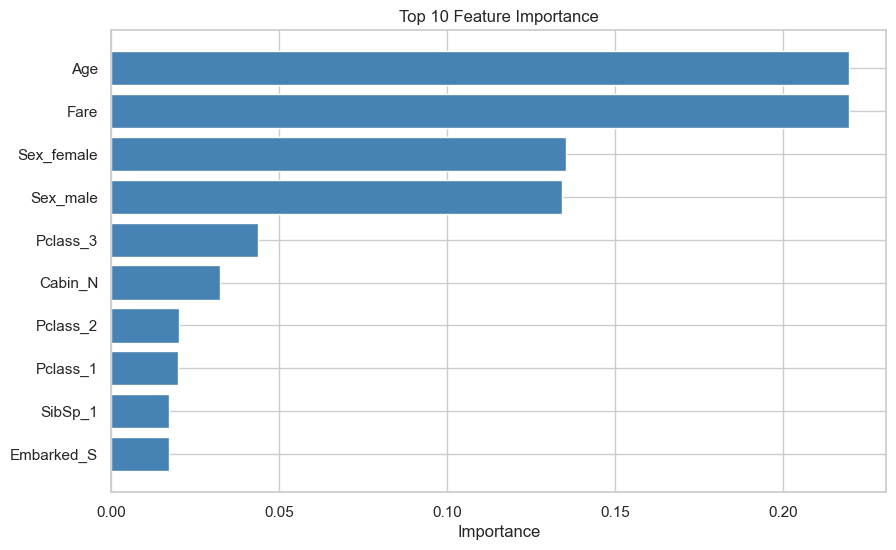

In [26]:
# Bar plot to visualize the most important features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10], color='steelblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()  # Invert the y-axis so the most important features are at the top
plt.show()

In [27]:
logger.info("Make predictions")

X_test_processed2 = preprocess_applier(preprocessor, test.drop('PassengerId', axis=1))
predictions = model.predict(X_test_processed2)
test["Survived"] = predictions
show(test, classes="display nowrap compact",maxBytes = 0)

2024-06-10 08:35:09.260 | INFO     | __main__:<module>:1 - Make predictions


## Conclusion


Throughout the machine learning phase of our Titanic dataset analysis, we successfully built and evaluated several predictive models to determine passenger survival. The process involved several critical steps:

1. **Data Preprocessing:** We prepared the data by handling missing values, encoding categorical variables, and scaling numerical features. This ensured that our data was clean and suitable for model training.

2. **Model Selection and Training:** We experimented with various machine learning algorithms, including Random Forest, Logistic Regression, K-Nearest Neighbors (KNN), LightGBM, AdaBoost, Decision Tree, and Gaussian Naive Bayes. Each model was trained using optimized hyperparameters to enhance performance.

3. **Evaluation Metrics:** We evaluated the models based on key metrics such as Accuracy, Precision, Recall, F1-Score, and AUC (Area Under the ROC Curve). This comprehensive evaluation allowed us to identify the strengths and weaknesses of each model.

4. **Best Model Identification:** Among the models, the Random Forest classifier emerged as the best-performing model with the highest AUC and a strong balance of precision and recall. This model demonstrated superior ability to distinguish between passengers who survived and those who did not.

5. **Feature Importance:** Using the Random Forest model, we identified the most important features contributing to the prediction of survival. This insight helps in understanding the factors that significantly influenced the survival chances of passengers.

6. **Predictions:** We utilized the best-performing model to make predictions on the test dataset, providing an actionable outcome based on our analysis.

7. **Results Documentation:** Finally, we saved the prediction results and the evaluation metrics of all models. This documentation ensures reproducibility and allows for further analysis and refinement.

Overall, the machine learning phase has provided us with valuable predictive insights and a robust model for assessing passenger survival on the Titanic. The comprehensive approach, from data preprocessing to model evaluation and deployment, underscores the importance of methodical and thorough analysis in achieving accurate and meaningful results.